## Read the training data and import library

In [166]:
import numpy as np
import pandas as pd
import pickle

In [167]:
class standardScaler():
    def fit(self, xss):
        self.mean = np.mean(xss, axis=0)
        self.sd = np.std(xss, axis=0)

    def transform(self, xss):
        xss = (xss-self.mean)/(self.sd)
        return(xss)

In [168]:
def polyTransform(xss):
    xss = np.column_stack([xss, xss**2])
    return(xss)

## Process the data 9 hours

In [183]:
def generate_Initial_Parameters(scale=True):
    # read data
    data = pd.read_csv('data/train.csv', encoding='Big5')
    data = data.replace('NR', '0')
    data = np.array(data)
    
    # feature variable
    hour = 9
    feature_num = 18
    day_per_month = 20
    per_month_row = feature_num * day_per_month
    total_month = int(len(data)/per_month_row) 
    
    month_data = []
    for i in range(total_month):
        l = data[i * per_month_row: i * per_month_row  + per_month_row]
        month_data.append(l)  

    hour_data = []
    for i in range(len(month_data)):
        tmp = []
        for j in range(len(month_data[i])):
            tmp.append(month_data[i][j])
        hour_data.append(tmp)

    total = []
    for i in range(len(hour_data)):
        df = pd.DataFrame(hour_data[i])
        row, col = df.shape
        tmp = None
        for j in range(day_per_month):
            per_day = df.iloc[j*feature_num:j*feature_num+feature_num,:]
            per_day = per_day.iloc[:,3:]

            if tmp is not None:
                tmp = pd.concat([tmp.reset_index(drop=True), per_day.reset_index(drop=True)], axis=1, ignore_index=True)
            else:
                tmp = pd.DataFrame(per_day)   

        total.append(tmp)
        
    xss = []
    yss = []
    ori_xss = []
    ori_yss = []

    for i in range(len(total)):
        df = total[i]
        row, col = df.shape
        for j in range(col-hour):
            xs = df.iloc[:,j:j+hour]
            xs = xs.values.ravel()
            ys = float(df.iloc[9,j+hour])

            ori_xss.append(xs)
            ori_yss.append(float(ys))

            if(ys < 0):
                continue
                
            xss.append(xs)
            yss.append(float(ys))

    xss = pd.DataFrame(xss).values.astype(np.float)
    yss = np.array(yss)
    ori_xss = pd.DataFrame(ori_xss).values.astype(np.float)
    ori_yss = np.array(ori_yss)

    if scale:
        ## feature scaling
        scaler = standardScaler()
        scaler.fit(xss)
        xss = scaler.transform(xss)
        row, col = xss.shape
    return ({'xss': xss, 'yss': yss, 'ori_xss': ori_xss, 'ori_yss': ori_yss})

## Feature Selection

In [226]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    
def calculate_vif_(X, thresh=150):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return (X.columns[variables], X[cols[variables]])

In [227]:
param = generate_Initial_Parameters()
xss = param['xss']
yss = param['yss']

In [ ]:
xss = polyTransform(xss)

In [ ]:
X_train = pd.DataFrame(xss)
xss = X_train.values

res = calculate_vif_(X_train)
selected_var, xss = res[0], res[1].values

## Select only past pm2.5 as factor

In [52]:
selected_var = np.array([  0,   2,   4,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29, 30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42, 43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77, 78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90, 91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,  156, 157, 158, 159, 160, 161]) 

In [186]:
# selected_var = np.array([(i)*feature_num +9 for i in range(9)]
X_train = X_train[selected_var]

## Train Test Split

In [187]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(xss, yss, test_size=0.2, random_state=42)

## Train the model. Don't forget to remove the clear_output

In [208]:
from IPython.display import clear_output

def gradientDescent(xss, yss , alpha):
    lr = 1
    max_iter = 10 ** 3
    epochs = 200
    
    ## get bias
    xss = np.column_stack(([1] * len(xss) ,xss))
    num = xss.shape[1]
    w = np.zeros(num)
    w_lr = np.zeros(num)
    
    for t in range(epochs):
        w_grad = None
        for m in range(max_iter):
            predict = np.dot(xss,w)
            w_grad = -(2 * np.dot(xss.T,(yss - predict))) + (alpha * np.sum(w**2) * 2)
            w_lr = w_lr + w_grad ** 2
            w = w - lr/np.sqrt(w_lr) * w_grad

        clear_output()
        print(t)
        print(np.sqrt(np.mean([ x*x for x in (yss-predict)])))
        
    return (w)

In [219]:
# alpha_list = [0.1, 0.01, 0.001, 0.0001]
alpha_list = [0.01]
his = []
for alpha in alpha_list:
    print(alpha)
    w = gradientDescent(X_train, Y_train, alpha)
    ori_xss = np.column_stack(([1] * len(X_test) ,X_test))
    ori_yss = Y_test

    predict = np.dot(ori_xss,w)
    rmse = (np.sqrt(np.mean([ x*x for x in (ori_yss-predict)])))
    his.append(rmse)

199
5.564586279416581


In [221]:
xss.shape
# w = gradientDescent(xss, yss, alpha = 0.01)

(5480, 149)

In [ ]:
test = pd.read_csv('data/test.csv', encoding='Big5', header=None)
test = test.replace('NR', '0')
file = '0305-2'

In [ ]:
import pickle
dic = {'w': w, 'scaler': scaler, 'selected_var' : selected_var}
with open('model/'+file+'.pkl', 'wb') as f:
    pickle.dump(dic, f)

In [ ]:
ans = pd.read_csv('data/sampleSubmission.csv', encoding='Big5')
test_feature = 18
total_test = []
row, col = test.shape
test_number = int(row/test_feature)
print(test_number)
for i in range(test_number):
    df = test.iloc[i*test_feature:(i+1)*test_feature, 2:]
    xs = df.values.ravel().astype(np.float)
    xs = (scaler.transform([xs])[0])
    xs = [xs[i] for i in range(len(xs)) if i in selected_var]
    xs = np.concatenate(([1], xs))
    val = np.dot(xs,w)
    if val < 0:
        val = (round(val,0))
    else:
        print(val)
        break
    ans.iloc[i,1] = val
# ans.to_csv('data/'+file+'.csv',index=False)

120


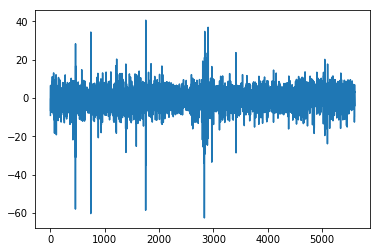

In [217]:
import matplotlib.pyplot as plt
with open('model/0304-3.pkl', 'rb') as f:
    dic = pickle.load(f)

w = dic['w']
scaler = dic['scaler']
selected_var = dic['selected_var']

param = generate_Initial_Parameters()
xss = param['xss']
yss = param['yss']

xss = xss[:,selected_var]

val = np.column_stack(([1] * len(xss) ,xss))
predict = np.dot(val,w)
# predict = np.array([max(0,predict[i]) for i in range(len(predict))])

error = (predict-yss)
plt.plot(error)

outlier = [ i for i in range(len(error)) if abs(error[i]) >= 13]
print(len(outlier))

xss = [ xss[i] for i in range(len(xss)) if i not in outlier]
yss = [ yss[i] for i in range(len(yss)) if i not in outlier]
xss = pd.DataFrame(xss)